#First GAN with MNIST

Create a simple Generative Adversarial Network that will be trainined on the MNIST dataset

#Imports 

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt 
from IPython import display 

#Utilities

This will plot the fake images and will be used to visualize sample outputs from the GAN while it's being trained

In [2]:
def plot_multiple_images(images, n_cols=None, epoch=0):
  """
  Visualize fake images 
  """

  display.clear_output(wait=False)
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1

  if images.shape[-1] == 1:
    images = np.squeeze(images, axis = -1)

  fig = plt.figure(figsize=(n_cols, n_rows))
  fig.suptitle(f'Epochs {epoch}', fontsize='x-large')
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

#Download and Prep the Dataset

Load the MNIST dataset but only use the training images (don't get the `test` split or the training labels). Make sure to preprocess the the images by normalizing the pixel values 

In [5]:
#Load the train set of the MNIST dataset
(X_train, _), _ = keras.datasets.mnist.load_data()

#Normalize pixel values 
X_train = X_train.astype(np.float32) / 255

In [6]:
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(1)

##Build the Model

Two main parts of the GAN:
* generator: creates the fake data
* discriminator: determines if an image is fake 

Stack Dense layers using the sequential API to build the sub networks 

#Generator 

The generatro take in random noise and uses it to create fake images. To do that, the model takes in the shape of the random noise and outputs an image with the same dimensions of the MNIST dataset (28 x 28)
* Instead of using `relu` for the activation, use `selu`
 * The reason is that relu works to remove noise from the model by not allowing any negative values that could cancel out positive values, passing through

* The final dense network is activated by a `sigmoid` function because the generated pixel values should be between 0 and 1

In [8]:
#Declare the shape of the noise dataset 
random_normal_dimensions = 32

#Build the generator model 
generator = keras.models.Sequential([
        keras.layers.Dense(64, activation='selu', input_shape=[random_normal_dimensions]),
        keras.layers.Dense(128, activation='selu'),
        keras.layers.Dense(28 * 28, activation='sigmoid'),
        keras.layers.Reshape([28, 28])
])

Check the sample output of an untrained generator (this should just look like random noise)

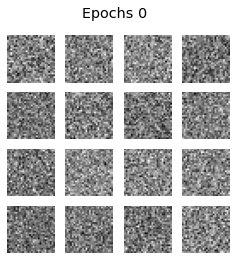

In [9]:
#generate a batch of noise input (batch size = 16)
test_noise =tf.random.normal([16, random_normal_dimensions]),

#Feed the batch to the untrained generator 
test_image = generator(test_noise)

#Visualize sample output
plot_multiple_images(test_image, n_cols=4)

#Discriminator

This will take in the input (fake or real) images and will determine if it is fake or not. The input shape will be taht of the training images which will be flattened so it can be fed to the dense networks and the final output is a value between 0 (fake) and 1 (real)

It will also implement `selu` activation in the first two dense networks and then the final Dense layer will be activated by a sigmoid function

In [10]:
#Build the discriminator model 
discriminator = keras.models.Sequential([
          keras.layers.Flatten(input_shape=[28, 28]),
          keras.layers.Dense(128, activation='selu'),
          keras.layers.Dense(64, activation='selu'),
          keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
#Append the two models together to make the GAN 
gan = keras.models.Sequential([generator, discriminator])

#Configure the training parameters 

Use `binary_crossentropy` since the model is expecting labels to be either 0 or 1 (fake or real)

In [13]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

#Train the Model

Define the training loop. This will consist of two phases:
* Phase 1: trains the discriminator to distinguish between fake or real data
* Phase 2: trains the generator to generate image that will trick the discriminator

At each epoch, display a sample gallery of image to see the fake images being create by the generator. 

In [17]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
  """Defines the two-phase training loop of the GAN
  Args:
    gan -- the GAN model which has the generator and discriminator
    dataset -- the training set of real image
    random_normal_dimensions -- dimensionality of the input to the generator
    n_epochs -- number of epochs
  """
  # get the two sub networks from the GAN model
  generator, discriminator = gan.layers

  # start loop
  for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))       
    for real_images in dataset:
        # infer batch size from the training batch
        batch_size = real_images.shape[0]

        # Train the discriminator - PHASE 1
        # Create the noise
        noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
        
        # Use the noise to generate fake images
        fake_images = generator(noise)
        
        # Create a list by concatenating the fake images with the real ones
        mixed_images = tf.concat([fake_images, real_images], axis=0)
        
        # Create the labels for the discriminator
        # 0 for the fake images
        # 1 for the real images
        discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # Ensure that the discriminator is trainable
        discriminator.trainable = True
        
        # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
        discriminator.train_on_batch(mixed_images, discriminator_labels)
        
        # Train the generator - PHASE 2
        # create a batch of noise input to feed to the GAN
        noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

        # label all generated images to be "real"
        generator_labels = tf.constant([[1.]] * batch_size)

        # Freeze the discriminator
        discriminator.trainable = False

        # Train the GAN on the noise with the labels all set to be true
        gan.train_on_batch(noise, generator_labels)

    # plot the fake images used to train the discriminator
    plot_multiple_images(fake_images, 8, epoch)

    plt.show() 

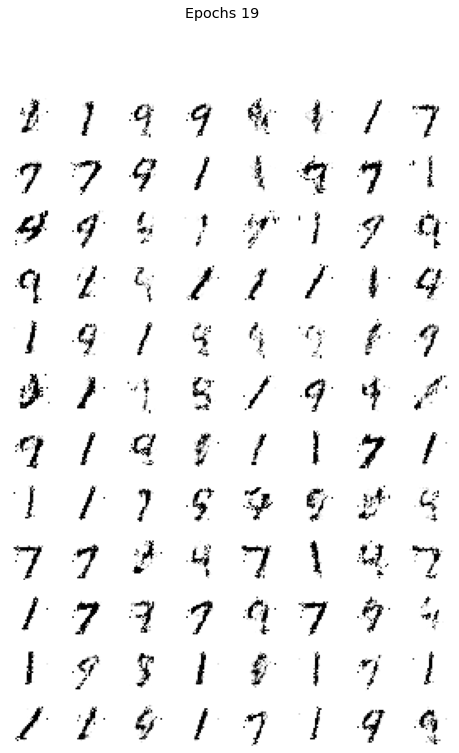

In [18]:
train_gan(gan, dataset, random_normal_dimensions, n_epochs=20)


In [19]:
import imageio
import glob

imageio.plugins.freeimage.download()

!rm -rf ./results/gane-mnist-anim.gif

anim_file = './gane-mnist-anim.gif'

filenames = glob.glob('/content/image_at_epoch_*.png')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=1)

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)2293760/4830080 bytes (47.5%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.
